In [1]:
import joblib
import pickle

import time
import datetime
import numpy as np
import pandas as pd
from keras.src.saving import load_model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer
from nltk import word_tokenize
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.src.utils import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cpu")
device

device(type='cpu')

### Funktionen

#### Datenvorbereitung etc.

In [4]:
def create_dataset(tokenizer, max_len, labels_data, tweets_data):
    input_ids = []
    attention_masks = []

    for tweet in tweets_data:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_data)
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [5]:
def get_dataloader(batch_size, dataset, sampler):
    if sampler == "random":
        return DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=batch_size
        )

    if sampler == "sequential":
        return DataLoader(
            dataset,
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )

In [6]:
def get_max_len(tweets, tokenizer):
    max_len = 0

    for sent in tweets:
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
    return max_len

In [7]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [8]:
def vectorize_w2v(tweets, loaded_vectorizer, vector_size=300):
    x_tokenized = tweets.map(word_tokenize)

    def w2v_vector(x_tokenized, vector_size):
        vec = np.zeros(vector_size).reshape((1, vector_size))
        count = 0
        for word in x_tokenized:
            try:
                vec += loaded_vectorizer.wv[word].reshape((1, vector_size))
                count += 1
            except KeyError:

                continue
        if count != 0:
            vec /= count
        return vec

    tweets_w2v = np.zeros((len(x_tokenized), 300))
    for i in range(len(x_tokenized)):
        tweets_w2v[i, :] = w2v_vector(x_tokenized.iloc[i], 300)

    return tweets_w2v

In [9]:
def tokenize_and_vectorize_for_lstm(tokenizer, glove_embeddings, tweets, vector_size=200, max_seq_len=50):
    X_sequences = tokenizer.texts_to_sequences(tweets)
    X_padded = pad_sequences(X_sequences, padding='post', maxlen=max_seq_len)

    def get_glove_vectors(sequence, glove_embeddings, vector_size, max_seq_len):
        vectors = [glove_embeddings.get(tokenizer.index_word.get(idx, ''), np.zeros(vector_size)) for idx in sequence]

        # Padding sicherstellen
        if len(vectors) < max_seq_len:
            vectors.extend([np.zeros(vector_size)] * (max_seq_len - len(vectors)))
        else:
            vectors = vectors[:max_seq_len]

        return np.array(vectors, dtype=np.float32)

    X_vectors = np.array([get_glove_vectors(seq, glove_embeddings, vector_size, max_seq_len) for seq in X_padded],
                         dtype=np.float32)

    return X_vectors

#### Evaluationsfunktionen

In [10]:
def print_wordcloud(dataframe, tweet_col, label_col):
    dataset_0_text = " ".join(dataframe[dataframe[label_col] == 0][tweet_col].tolist())
    dataset_1_text = " ".join(dataframe[dataframe[label_col] == 1][tweet_col].tolist())

    plt.figure(figsize=(12, 6))

    # Subplot 1: Dataset 0
    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='RdYlGn').generate(
        dataset_0_text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 0)", fontsize=14)

    # Subplot 2: Dataset 1
    plt.subplot(1, 2, 2)
    wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='Paired').generate(
        dataset_1_text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 1)", fontsize=14)

    plt.tight_layout()
    plt.show()

##### Metriken

In [11]:
def get_predictions_bert(test_dataloader, model):
    predictions = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

        batches_completed += 1

    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions

In [12]:
def add_to_eval_df(model_name, y_prediction, y_true, sample_size, df, dataset_name, threshold):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    mcc = matthews_corrcoef(y_true, y_prediction)

    df.loc[len(df.index)] = [model_name, dataset_name, sample_size, threshold, accuracy, precision, recall, f1, mcc]

In [13]:
def eval_model_bert(tokenizer, model, model_name, labels, tweets, batch_size, data_size, df, dataset_name, threshold,
                    max_len=None):
    if max_len is None:
        max_len = get_max_len(tweets, tokenizer)
    dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=labels,
                             tweets_data=tweets)
    dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=dataset)
    predictions = get_predictions_bert(test_dataloader=dataloader, model=model)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [14]:
# geeignet für tf-idf bayes und ensemble
def eval_classic_model(vectorizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold):
    X_vectorized = vectorizer.transform(tweets)
    predictions = (model.predict_proba(X_vectorized)[:, 1] >= threshold)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [15]:
def eval_model_svm(vectorizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold):
    X_vectorized = vectorizer.transform(tweets)
    predictions = model.predict(X_vectorized)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [16]:
def eval_model_gru(tokenizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold, max_len):
    X_data = [str(x) for x in tweets]
    tweets_seq = tokenizer.texts_to_sequences(X_data)
    tweets_padded = pad_sequences(tweets_seq, padding='post', maxlen=max_len)
    predictions = (model.predict(tweets_padded) > threshold).astype(int)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [17]:
def eval_model_lstm(tokenizer, vectorizer, model, labels, tweets, threshold, model_name, data_size, df, dataset_name):
    X_data_vectorized = tokenize_and_vectorize_for_lstm(
        glove_embeddings=vectorizer,
        tweets=tweets,
        tokenizer=tokenizer
    )

    predictions = (model.predict(X_data_vectorized) > threshold).astype(int)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

##### Wahrscheinlichkeiten

In [18]:
def get_predictions_with_probabilities_bert(test_dataloader, model, threshold):
    predictions = []
    predictions_proba = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            pred_with_thresh = [1 if value[1] > threshold else 0 for value in output.logits.softmax(dim=-1).tolist()]
            pred_with_thresh = np.array(pred_with_thresh)

            predictions.extend(list(pred_with_thresh))
            predictions_proba.extend(output.logits.softmax(dim=-1).tolist())

        batches_completed += 1

    print("Prediction finished.")
    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions, predictions_proba

In [19]:
def add_to_detail_eval_df(dataframe, predictions, probabilities=None):
    if probabilities is not None:
        dataframe["zero_proba"] = pd.Series((v[0] for v in probabilities), index=dataframe.index)
        dataframe["one_proba"] = pd.Series((v[1] for v in probabilities), index=dataframe.index)
    else:
        dataframe["zero_proba"] = 0
        dataframe["one_proba"] = 0
    dataframe["pred"] = predictions

    return dataframe

In [20]:
def add_pred_and_probas_bert(model, tokenizer, data, label_name, tweet_name, batch_size, threshold):
    x_data = data[tweet_name].values
    y_data = data[label_name].values
    max_len = get_max_len(x_data, tokenizer)
    test_dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=y_data,
                                  tweets_data=x_data)
    test_dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=test_dataset)

    predictions, predictions_proba = get_predictions_with_probabilities_bert(test_dataloader=test_dataloader,
                                                                             model=model, threshold=threshold)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=predictions_proba)

In [21]:
def add_pred_and_probas(model, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_vectorized = vectorizer.transform(x_data)
    probabilities = model.predict_proba(X_vectorized)
    predictions = (probabilities[:, 1] >= threshold).astype(int)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

In [22]:
def add_pred_and_probas_svm(model, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_vectorized = vectorizer.transform(x_data)
    predictions = model.predict(X_vectorized)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions)

    return data

In [23]:
def add_pred_and_probas_gru(model, tokenizer, data, tweet_name, threshold, max_len):
    x_data = data[tweet_name].values

    X_data = [str(x) for x in x_data]
    tweets_seq = tokenizer.texts_to_sequences(X_data)
    tweets_padded = pad_sequences(tweets_seq, padding='post', maxlen=max_len)

    probabilities = model.predict(tweets_padded)
    predictions = (probabilities > threshold).astype(int)

    new_array = []
    for proba in probabilities:
        complement = 1 - proba[0]
        new_array.append([complement, proba[0]])
    probabilities = pd.Series(new_array)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

In [24]:
def add_pred_and_probas_lstm(model, tokenizer, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_data_vectorized = tokenize_and_vectorize_for_lstm(
        glove_embeddings=vectorizer,
        tweets=x_data,
        tokenizer=tokenizer
    )

    probabilities = model.predict(X_data_vectorized)
    predictions = (probabilities > threshold).astype(int)

    new_array = []
    for proba in probabilities:
        complement = 1 - proba[0]
        new_array.append([complement, proba[0]])
    probabilities = pd.Series(new_array)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

### 1. Modelle

In [25]:
MODELS_PATH = "../../webapp/backend/app/models"

#### 1.1 Bayes

In [26]:
nb_vectorizer = joblib.load(MODELS_PATH + "/nb/vectorizer_nb_tfidf.joblib")
nb_model = joblib.load(MODELS_PATH + "/nb/model_nb_tfidf_comp.joblib")
nb_modelname = "ComplementNB"

#### 1.2 Ensemble

In [27]:
ensemble_vectorizer = joblib.load(MODELS_PATH + "/ensemble/tfidf_vectorizer_for_brf.joblib")
ensemble_model = joblib.load(MODELS_PATH + "/ensemble/tfidf_balancedrandomforest.joblib")
ensemble_modelname = "BalancedRandomForest"

#### 1.3 SVM

In [28]:
svm_vectorizer = joblib.load(MODELS_PATH + "/svc/tfidf_vectorizer_svc_linear.joblib")
svm_model = joblib.load(MODELS_PATH + "/svc/svc_linear_best.joblib")
svm_modelname = "LinearSVC"

#### 1.4 RNN-GRU

In [29]:
max_len_gru = 40
gru_model = load_model(MODELS_PATH + "/gru/gru-model_mixed-dataset.keras")
with open(MODELS_PATH + "/gru/tokenizer_mixed-dataset.pkl", 'rb') as f:
    gru_tokenizer = pickle.load(f)
gru_modelname = "RNN-GRU"

#### 1.5 RNN-LSTM

In [30]:
lstm_model = load_model(MODELS_PATH + "/lstm/model_lstm_17.keras")
with open(MODELS_PATH + "/lstm/tokenizer_lstm.json", "r", encoding="utf-8") as f:
    tokenizer_data = f.read()
    lstm_tokenizer = tokenizer_from_json(tokenizer_data)
lstm_glove_embeddings = {}
with open(MODELS_PATH + "/lstm/glove.6B.200d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        lstm_glove_embeddings[word] = vector
lstm_modelname = "RNN-LSTM"

#### 1.6 BERT

In [31]:
PATH_BERT_TUNED = MODELS_PATH + "/bert/bert_mixed_imran"
bert_tokenizer = BertTokenizer.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
bert_model = AutoModelForSequenceClassification.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
bert_modelname = "bert_tuned_uncased"

#### 1.7 RoBERTa

In [32]:
PATH_ROBERTA_TUNED = MODELS_PATH + "/roberta/roberta_hate_mixed_cleaned"
roberta_tokenizer = AutoTokenizer.from_pretrained(PATH_ROBERTA_TUNED, local_files_only=True)
roberta_model = AutoModelForSequenceClassification.from_pretrained(PATH_ROBERTA_TUNED, local_files_only=True)
roberta_modelname = "roberta_hate_mixed_cleaned"

### 2. Daten

In [33]:
sample_size = None  # setzen, um nur für eine Stichprobe der Daten die Metriken zu bestimmen

#### 2.1 Mixed-Train (cleaned)

In [34]:
df_mixed_train_cleaned = pd.read_csv("../../data/mixed_dataset/train_cleaned.csv", index_col=0)
df_mixed_train_cleaned = df_mixed_train_cleaned[df_mixed_train_cleaned.tweet_cleaned.notna()]
if sample_size is not None:
    df_mixed_train_cleaned = df_mixed_train_cleaned.sample(n=sample_size)

df_mixed_train_cleaned = df_mixed_train_cleaned[["label", "tweet_cleaned"]]
df_mixed_train_cleaned.head(1)

,label,tweet_cleaned
140232,0,"nickis "" good pout buy botox trade mark mkr"


#### 2.2 Mixed-Train (cleaned-rnn)

In [35]:
df_mixed_train_cleaned_rnn = pd.read_csv("../../data/mixed_dataset/train_cleaned_rnn.csv", index_col=0)
df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn[df_mixed_train_cleaned_rnn.tweet_cleaned.notna()]
if sample_size is not None:
    df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn.sample(n=sample_size)

df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn[["label", "tweet_cleaned"]]
df_mixed_train_cleaned_rnn.head(1)

,label,tweet_cleaned
140232,0,"nickis ""thats not good"" pout bought to you by ..."


#### 2.3 Mixed-Train (uncleaned)

In [36]:
df_mixed_train_uncleaned = pd.read_csv("../../data/mixed_dataset/train_cleaned.csv", index_col=0)
df_mixed_train_uncleaned = df_mixed_train_uncleaned[df_mixed_train_uncleaned.tweet.notna()]
if sample_size is not None:
    df_mixed_train_uncleaned = df_mixed_train_uncleaned.sample(n=sample_size)

df_mixed_train_uncleaned = df_mixed_train_uncleaned[["label", "tweet"]]
print(df_mixed_train_uncleaned.head(1))
print("Daten: \t", len(df_mixed_train_uncleaned))

        label                                              tweet
140232      0  Nicki's "that's not good" pout bought to you b...
Daten: 	 81905


#### 2.4 Mixed-Test (cleaned)

In [37]:
df_mixed_test_cleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_cleaned = df_mixed_test_cleaned[df_mixed_test_cleaned.tweet_cleaned.notna()]
if sample_size is not None:
    df_mixed_test_cleaned = df_mixed_test_cleaned.sample(n=sample_size)

df_mixed_test_cleaned = df_mixed_test_cleaned[["label", "tweet_cleaned"]]
print(df_mixed_test_cleaned.head(1))
print("Daten: \t", len(df_mixed_test_cleaned))

      label                                 tweet_cleaned
8886      0  final gear evening butterfly stage hope like
Daten: 	 32466


#### 2.5 Mixed-Test (cleaned-RNN)

In [38]:
df_mixed_test_cleaned_rnn = pd.read_csv("../../data/mixed_dataset/test_cleaned_rnn.csv", index_col=0)
df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn[df_mixed_test_cleaned_rnn.tweet_cleaned.notna()]
if sample_size is not None:
    df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn.sample(n=sample_size)

df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn[["label", "tweet_cleaned"]]
print(df_mixed_test_cleaned_rnn.head(1))
print("Daten: \t", len(df_mixed_test_cleaned_rnn))

      label                                      tweet_cleaned
8886      0  cinemaaawards final rehearsals gearing up for ...
Daten: 	 32529


#### 2.6 Mixed-Test (uncleaned)

In [39]:
df_mixed_test_uncleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_uncleaned = df_mixed_test_uncleaned[df_mixed_test_uncleaned.tweet.notna()]
if sample_size is not None:
    df_mixed_test_uncleaned = df_mixed_test_uncleaned.sample(n=sample_size)

df_mixed_test_uncleaned = df_mixed_test_uncleaned[["label", "tweet", ]]
print(df_mixed_test_uncleaned.head(1))
print("Daten: \t", len(df_mixed_test_uncleaned))

      label                                              tweet
8886      0   @user #cinemaaawards final rehearsals!! geari...
Daten: 	 32582


#### 2.7 Mixed-Test (manual-labeled, uncleaned, new)

In [40]:
df_mixed_manual_uncleaned_new = pd.read_csv("../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
df_mixed_manual_uncleaned_new = df_mixed_manual_uncleaned_new[df_mixed_manual_uncleaned_new.tweet.notna()]

df_mixed_manual_uncleaned_new = df_mixed_manual_uncleaned_new[["label_manual", "tweet", ]]
print(df_mixed_manual_uncleaned_new.head(1))
print("Daten: \t", len(df_mixed_manual_uncleaned_new))

   label_manual                                  tweet
0             1  Post the shit or kill yourself faggot
Daten: 	 430


#### 2.8 Mixed-Test (manual-labeled, uncleaned, old)

In [41]:
df_mixed_manual_uncleaned_old = pd.read_csv("../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
df_mixed_manual_uncleaned_old = df_mixed_manual_uncleaned_old[df_mixed_manual_uncleaned_old.label.notna()]

df_mixed_manual_uncleaned_old = df_mixed_manual_uncleaned_old[["label", "tweet", ]]
print(df_mixed_manual_uncleaned_old.head(1))
print("Daten: \t", len(df_mixed_manual_uncleaned_old))

   label                                  tweet
0      1  Post the shit or kill yourself faggot
Daten: 	 430


### 3. Allgemeine Evaluation - Metriken

In [42]:
def evaluate(label_col, tweet_col, data, dataset_name, threshold):
    evaluation_df = pd.DataFrame(
        columns=["model", "dataset_name", "sample_size", "threshold", "accuracy", "precision", "recall", "f1_score",
                 "mcc"])
    eval_classic_model(vectorizer=ensemble_vectorizer,
                       model=ensemble_model,
                       model_name=ensemble_modelname,
                       labels=data[label_col],
                       tweets=data[tweet_col],
                       data_size=len(data),
                       df=evaluation_df,
                       dataset_name=dataset_name,
                       threshold=threshold)

    eval_classic_model(vectorizer=nb_vectorizer,
                       model=nb_model,
                       model_name=nb_modelname,
                       labels=data[label_col],
                       tweets=data[tweet_col],
                       data_size=len(data),
                       df=evaluation_df,
                       dataset_name=dataset_name,
                       threshold=threshold)

    eval_model_svm(vectorizer=svm_vectorizer,
                   model=svm_model,
                   model_name=svm_modelname,
                   labels=data[label_col],
                   tweets=data[tweet_col],
                   data_size=len(data),
                   df=evaluation_df,
                   dataset_name=dataset_name,
                   threshold="None")

    eval_model_lstm(tokenizer=lstm_tokenizer,
                    vectorizer=lstm_glove_embeddings,
                    model=lstm_model,
                    model_name=lstm_modelname,
                    labels=data[label_col],
                    tweets=data[tweet_col],
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    eval_model_gru(tokenizer=gru_tokenizer,
                   model=gru_model,
                   model_name=gru_modelname,
                   labels=data[label_col],
                   tweets=data[tweet_col],
                   data_size=len(data),
                   df=evaluation_df,
                   dataset_name=dataset_name,
                   threshold=threshold,
                   max_len=40)

    eval_model_bert(tokenizer=bert_tokenizer,
                    model=bert_model,
                    model_name=bert_modelname,
                    labels=data[label_col].values,
                    tweets=data[tweet_col].values,
                    batch_size=16,
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    eval_model_bert(tokenizer=roberta_tokenizer,
                    model=roberta_model,
                    model_name=roberta_modelname,
                    labels=data[label_col].values,
                    tweets=data[tweet_col].values,
                    batch_size=16,
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    return evaluation_df

#### 3.1 Alle Datensätze - Schwellwert 0.5

##### 3.1.1 Mixed-Train (cleaned) - df_mixed_train_cleaned

In [43]:
evaluation_mixed_train_cleaned = pd.read_csv("evaluation_data/evaluation_mixed_train_cleaned.csv", index_col=0)

In [44]:
evaluation_mixed_train_cleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.5,0.923740,0.807912,0.756189,0.781195,0.735669
5,bert_tuned_uncased,df_mixed_train_cleaned,81904,0.5,0.906244,0.719250,0.786029,0.751158,0.694577
0,BalancedRandomForest,df_mixed_train_cleaned,81904,0.5,0.887112,0.630129,0.902950,0.742265,0.690745
4,RNN-GRU,df_mixed_train_cleaned,81904,0.5,0.825088,0.508996,0.803866,0.623317,0.539672
2,LinearSVC,df_mixed_train_cleaned,81904,NaN,0.795358,0.462185,0.835537,0.595155,0.510106
1,ComplementNB,df_mixed_train_cleaned,81904,0.5,0.772966,0.429482,0.795117,0.557715,0.459057
3,RNN-LSTM,df_mixed_train_cleaned,81904,0.5,0.709245,0.365465,0.835402,0.508483,0.403604


##### 3.1.2 Mixed-Train (cleaned-RNN) - df_mixed_train_cleaned_rnn

In [45]:
evaluation_mixed_train_cleaned_rnn = pd.read_csv("evaluation_data/evaluation_mixed_train_cleaned_rnn.csv", index_col=0)

In [46]:
evaluation_mixed_train_cleaned_rnn.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.5,0.935286,0.739827,0.985809,0.845286,0.818682
5,bert_tuned_uncased,df_mixed_train_cleaned_rnn,83305,0.5,0.852722,0.571124,0.717585,0.636032,0.550787
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned_rnn,83305,0.5,0.865218,0.617802,0.651382,0.634148,0.551902
0,BalancedRandomForest,df_mixed_train_cleaned_rnn,83305,0.5,0.838029,0.537481,0.694022,0.605802,0.512486
2,LinearSVC,df_mixed_train_cleaned_rnn,83305,NaN,0.802257,0.467059,0.727960,0.569029,0.467146
3,RNN-LSTM,df_mixed_train_cleaned_rnn,83305,0.5,0.753916,0.410159,0.849722,0.553260,0.462617
1,ComplementNB,df_mixed_train_cleaned_rnn,83305,0.5,0.640874,0.317697,0.873619,0.465949,0.355760


##### 3.1.3 Mixed-Train (uncleaned) - df_mixed_train_uncleaned

In [47]:
evaluation_mixed_train_uncleaned = pd.read_csv("evaluation_data/evaluation_mixed_train_uncleaned.csv", index_col=0)

In [48]:
evaluation_mixed_train_uncleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_uncleaned,81905,0.5,0.908724,0.693561,0.883215,0.776982,0.728963
5,bert_tuned_uncased,df_mixed_train_uncleaned,81905,0.5,0.830731,0.523727,0.659410,0.583789,0.484309
6,roberta_hate_mixed_cleaned,df_mixed_train_uncleaned,81905,0.5,0.826177,0.513170,0.671211,0.581646,0.481209
0,BalancedRandomForest,df_mixed_train_uncleaned,81905,0.5,0.823747,0.508095,0.657714,0.573303,0.470679
2,LinearSVC,df_mixed_train_uncleaned,81905,NaN,0.791002,0.450680,0.735300,0.558837,0.454280
3,RNN-LSTM,df_mixed_train_uncleaned,81905,0.5,0.754704,0.409119,0.816073,0.545010,0.446330
1,ComplementNB,df_mixed_train_uncleaned,81905,0.5,0.666138,0.332251,0.846253,0.477161,0.364599


##### 3.1.4 Mixed-Test (cleaned) - df_mixed_test_cleaned

In [49]:
evaluation_mixed_test_cleaned = pd.read_csv("evaluation_data/evaluation_mixed_test_cleaned.csv", index_col=0)

In [50]:
evaluation_mixed_test_cleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.5,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.5,0.833303,0.614069,0.561632,0.586681,0.483293
0,BalancedRandomForest,df_mixed_test_cleaned,32466,0.5,0.771453,0.471478,0.702149,0.564145,0.432463
2,LinearSVC,df_mixed_test_cleaned,32466,NaN,0.719707,0.412466,0.778915,0.539334,0.402253
4,RNN-GRU,df_mixed_test_cleaned,32466,0.5,0.746535,0.436518,0.698786,0.537359,0.395096
1,ComplementNB,df_mixed_test_cleaned,32466,0.5,0.714070,0.402939,0.741775,0.522209,0.375304
3,RNN-LSTM,df_mixed_test_cleaned,32466,0.5,0.654192,0.359142,0.817956,0.499130,0.349701


##### 3.1.5 Mixed-Test (cleaned-RNN) - df_mixed_test_cleaned_rnn

In [51]:
evaluation_mixed_test_cleaned_rnn = pd.read_csv("evaluation_data/evaluation_mixed_test_cleaned_rnn.csv", index_col=0)

In [52]:
evaluation_mixed_test_cleaned_rnn.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.5,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.5,0.801869,0.522474,0.677674,0.590039,0.469069
4,RNN-GRU,df_mixed_test_cleaned_rnn,32529,0.5,0.782625,0.488139,0.682496,0.569183,0.439911
0,BalancedRandomForest,df_mixed_test_cleaned_rnn,32529,0.5,0.768484,0.461981,0.609877,0.525726,0.382776
3,RNN-LSTM,df_mixed_test_cleaned_rnn,32529,0.5,0.692828,0.388637,0.802601,0.523691,0.383323
2,LinearSVC,df_mixed_test_cleaned_rnn,32529,NaN,0.736451,0.420899,0.672122,0.517639,0.367362
1,ComplementNB,df_mixed_test_cleaned_rnn,32529,0.5,0.571367,0.311006,0.853448,0.455883,0.288504


##### 3.1.6 Mixed-Test (uncleaned) - df_mixed_test_uncleaned

In [53]:
evaluation_mixed_test_uncleaned = pd.read_csv("evaluation_data/evaluation_mixed_test_uncleaned.csv", index_col=0)

In [54]:
evaluation_mixed_test_uncleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.5,0.790498,0.500997,0.660579,0.569826,0.442052
5,bert_tuned_uncased,df_mixed_test_uncleaned,32582,0.5,0.781045,0.484156,0.647428,0.554014,0.420551
4,RNN-GRU,df_mixed_test_uncleaned,32582,0.5,0.782088,0.485828,0.641146,0.552784,0.419261
3,RNN-LSTM,df_mixed_test_uncleaned,32582,0.5,0.696888,0.389729,0.782876,0.520396,0.376852
0,BalancedRandomForest,df_mixed_test_uncleaned,32582,0.5,0.762415,0.450806,0.600526,0.515005,0.368400
2,LinearSVC,df_mixed_test_uncleaned,32582,NaN,0.724357,0.406608,0.679719,0.508832,0.354964
1,ComplementNB,df_mixed_test_uncleaned,32582,0.5,0.596495,0.321717,0.830947,0.463847,0.298526


##### 3.1.7 Mixed-Test (manual-labeled, uncleaned, new) - df_mixed_manual_uncleaned_new

In [55]:
evaluation_mixed_manual_uncleaned_new = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new.csv", index_col=0)

In [56]:
evaluation_mixed_manual_uncleaned_new.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.5,0.879070,0.883436,0.813559,0.847059,0.749074
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,430,0.5,0.816279,0.766304,0.796610,0.781163,0.623297
4,RNN-GRU,df_mixed_manual_uncleaned_new,430,0.5,0.813953,0.797546,0.734463,0.764706,0.612710
3,RNN-LSTM,df_mixed_manual_uncleaned_new,430,0.5,0.772093,0.670996,0.875706,0.759804,0.567828
2,LinearSVC,df_mixed_manual_uncleaned_new,430,NaN,0.788372,0.723958,0.785311,0.753388,0.570030
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,430,0.5,0.793023,0.775000,0.700565,0.735905,0.568396
1,ComplementNB,df_mixed_manual_uncleaned_new,430,0.5,0.718605,0.603704,0.920904,0.729306,0.507009


##### 3.1.8 Mixed-Test (manual-labeled, uncleaned, old) - df_mixed_manual_uncleaned_old

In [57]:
evaluation_mixed_manual_uncleaned_old = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old.csv", index_col=0)

In [58]:
evaluation_mixed_manual_uncleaned_old.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,430,0.5,0.830233,0.791411,0.767857,0.779456,0.641705
5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,430,0.5,0.786047,0.706522,0.773810,0.738636,0.559822
4,RNN-GRU,df_mixed_manual_uncleaned_old,430,0.5,0.797674,0.748466,0.726190,0.737160,0.572933
2,LinearSVC,df_mixed_manual_uncleaned_old,430,NaN,0.767442,0.677083,0.773810,0.722222,0.527201
3,RNN-LSTM,df_mixed_manual_uncleaned_old,430,0.5,0.741860,0.623377,0.857143,0.721805,0.513807
0,BalancedRandomForest,df_mixed_manual_uncleaned_old,430,0.5,0.758140,0.700000,0.666667,0.682927,0.488005
1,ComplementNB,df_mixed_manual_uncleaned_old,430,0.5,0.669767,0.548148,0.880952,0.675799,0.419207


##### Vergleich aller Datensätze bei Schwellwerte 0.5


In [59]:
df_list_50 = [
    evaluation_mixed_train_cleaned,
    evaluation_mixed_train_cleaned_rnn,
    evaluation_mixed_train_uncleaned,
    evaluation_mixed_test_cleaned,
    evaluation_mixed_test_cleaned_rnn,
    evaluation_mixed_test_uncleaned,
    evaluation_mixed_manual_uncleaned_new,
    evaluation_mixed_manual_uncleaned_old]

all_eval_50_dfs = pd.concat(df_list_50, axis=0)

In [60]:
# allgemeine Sortierung aller Datensätze nach F1-Score
all_eval_50_dfs.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.5,0.879070,0.883436,0.813559,0.847059,0.749074
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.5,0.935286,0.739827,0.985809,0.845286,0.818682
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.5,0.923740,0.807912,0.756189,0.781195,0.735669
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,430,0.5,0.816279,0.766304,0.796610,0.781163,0.623297
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,430,0.5,0.830233,0.791411,0.767857,0.779456,0.641705
4,RNN-GRU,df_mixed_train_uncleaned,81905,0.5,0.908724,0.693561,0.883215,0.776982,0.728963
4,RNN-GRU,df_mixed_manual_uncleaned_new,430,0.5,0.813953,0.797546,0.734463,0.764706,0.612710
3,RNN-LSTM,df_mixed_manual_uncleaned_new,430,0.5,0.772093,0.670996,0.875706,0.759804,0.567828
2,LinearSVC,df_mixed_manual_uncleaned_new,430,NaN,0.788372,0.723958,0.785311,0.753388,0.570030
5,bert_tuned_uncased,df_mixed_train_cleaned,81904,0.5,0.906244,0.719250,0.786029,0.751158,0.694577


In [61]:
# Filterung nur auf die 3 Testdatensätze und Sortierung nach F1-Score
all_eval_50_dfs[(all_eval_50_dfs.dataset_name == "df_mixed_test_cleaned") | (all_eval_50_dfs.dataset_name == "df_mixed_test_cleaned_rnn") | (all_eval_50_dfs.dataset_name == "df_mixed_test_uncleaned")].sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.5,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.5,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.5,0.801869,0.522474,0.677674,0.590039,0.469069
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.5,0.833303,0.614069,0.561632,0.586681,0.483293
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.5,0.790498,0.500997,0.660579,0.569826,0.442052
4,RNN-GRU,df_mixed_test_cleaned_rnn,32529,0.5,0.782625,0.488139,0.682496,0.569183,0.439911
0,BalancedRandomForest,df_mixed_test_cleaned,32466,0.5,0.771453,0.471478,0.702149,0.564145,0.432463
5,bert_tuned_uncased,df_mixed_test_uncleaned,32582,0.5,0.781045,0.484156,0.647428,0.554014,0.420551
4,RNN-GRU,df_mixed_test_uncleaned,32582,0.5,0.782088,0.485828,0.641146,0.552784,0.419261
2,LinearSVC,df_mixed_test_cleaned,32466,NaN,0.719707,0.412466,0.778915,0.539334,0.402253


<Axes: xlabel='model', ylabel='f1_score'>

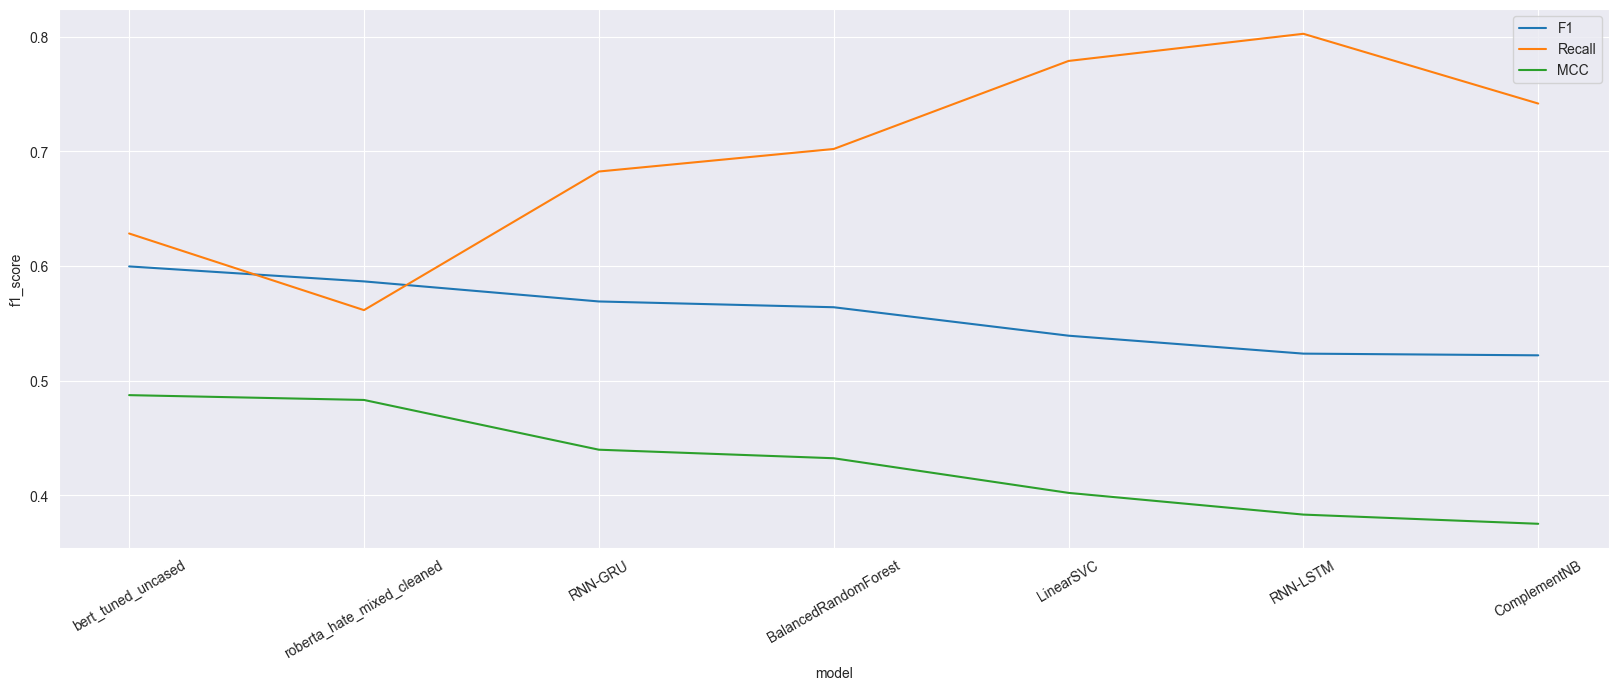

In [62]:
# Filterung nur auf den jeweils besten cleaned Datensatz (für GRU und LSTM der _rnn-Datensatz)
best_cleaned = all_eval_50_dfs[((all_eval_50_dfs.dataset_name == "df_mixed_test_cleaned") & ((all_eval_50_dfs.model != "RNN-GRU") & (all_eval_50_dfs.model != "RNN-LSTM"))) |
                ((all_eval_50_dfs.dataset_name == "df_mixed_test_cleaned_rnn") & ((all_eval_50_dfs.model == "RNN-GRU") | (all_eval_50_dfs.model == "RNN-LSTM")))].sort_values(by=["f1_score"], ascending=False)

fig, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)
sns.lineplot(data=best_cleaned, y=best_cleaned.f1_score, x=best_cleaned.model, label="F1")
sns.lineplot(data=best_cleaned, y=best_cleaned.recall, x=best_cleaned.model, label="Recall")
sns.lineplot(data=best_cleaned, y=best_cleaned.mcc, x=best_cleaned.model, label="MCC")

###### Erkenntnisse Schwellwert 0.5
- manuell gelabelte Datensätze erzielen bei den Testdatensätzen die besten Ergebnisse, alle Modelle unter den besten F1-Werten vertreten
- deutliche Unterschiede (-20-25%) zwischen manuell gelabelt und regulären Testdaten (volle Samplesize)
- cleaned erzielt für das jeweilige Modell grundsätzlich die besten Ergebnisse (bei GRU und LSTM der RNN-Datensatz), ansonsten aber im Schnitt 3-5% Unterschied von cleaned zu uncleaned

#### 3.2 Alle Datensätze - Schwellwert 0.35

##### 3.2.1 Mixed-Train (cleaned) - df_mixed_train_cleaned

In [63]:
evaluation_mixed_train_cleaned2 = pd.read_csv("evaluation_data/evaluation_mixed_train_cleaned2.csv", index_col=0)

In [64]:
evaluation_mixed_train_cleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.35,0.923740,0.807912,0.756189,0.781195,0.735669
5,bert_tuned_uncased,df_mixed_train_cleaned,81904,0.35,0.906244,0.719250,0.786029,0.751158,0.694577
4,RNN-GRU,df_mixed_train_cleaned,81904,0.35,0.800303,0.469796,0.849712,0.605061,0.524056
0,BalancedRandomForest,df_mixed_train_cleaned,81904,0.35,0.776617,0.443722,0.949407,0.604787,0.543255
2,LinearSVC,df_mixed_train_cleaned,81904,NaN,0.795358,0.462185,0.835537,0.595155,0.510106
3,RNN-LSTM,df_mixed_train_cleaned,81904,0.35,0.675291,0.342362,0.872703,0.491793,0.389101
1,ComplementNB,df_mixed_train_cleaned,81904,0.35,0.589178,0.297868,0.944591,0.452914,0.353772


##### 3.2.2 Mixed-Train (cleaned-RNN) - df_mixed_train_cleaned_rnn

In [65]:
evaluation_mixed_train_cleaned_rnn2 = pd.read_csv("evaluation_data/evaluation_mixed_train_cleaned_rnn2.csv", index_col=0)

In [66]:
evaluation_mixed_train_cleaned_rnn2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.35,0.912358,0.673828,0.990963,0.802189,0.771465
5,bert_tuned_uncased,df_mixed_train_cleaned_rnn,83305,0.35,0.852722,0.571124,0.717585,0.636032,0.550787
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned_rnn,83305,0.35,0.865218,0.617802,0.651382,0.634148,0.551902
2,LinearSVC,df_mixed_train_cleaned_rnn,83305,NaN,0.802257,0.467059,0.727960,0.569029,0.467146
0,BalancedRandomForest,df_mixed_train_cleaned_rnn,83305,0.35,0.772367,0.429606,0.821943,0.564279,0.471490
3,RNN-LSTM,df_mixed_train_cleaned_rnn,83305,0.35,0.704159,0.368475,0.910101,0.524567,0.439641
1,ComplementNB,df_mixed_train_cleaned_rnn,83305,0.35,0.450153,0.242920,0.976170,0.389030,0.266228


##### 3.2.3 Mixed-Train (uncleaned) - df_mixed_train_uncleaned

In [67]:
evaluation_mixed_train_uncleaned2 = pd.read_csv("evaluation_data/evaluation_mixed_train_uncleaned2.csv", index_col=0)

In [68]:
evaluation_mixed_train_uncleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_uncleaned,81905,0.35,0.887858,0.630284,0.912106,0.745448,0.695590
5,bert_tuned_uncased,df_mixed_train_uncleaned,81905,0.35,0.830731,0.523727,0.659410,0.583789,0.484309
6,roberta_hate_mixed_cleaned,df_mixed_train_uncleaned,81905,0.35,0.826177,0.513170,0.671211,0.581646,0.481209
2,LinearSVC,df_mixed_train_uncleaned,81905,NaN,0.791002,0.450680,0.735300,0.558837,0.454280
0,BalancedRandomForest,df_mixed_train_uncleaned,81905,0.35,0.757866,0.410456,0.790709,0.540394,0.437011
3,RNN-LSTM,df_mixed_train_uncleaned,81905,0.35,0.705427,0.366869,0.876704,0.517277,0.422561
1,ComplementNB,df_mixed_train_uncleaned,81905,0.35,0.463024,0.247399,0.970973,0.394326,0.272100


##### 3.2.4 Mixed-Test (cleaned) - df_mixed_test_cleaned

In [69]:
evaluation_mixed_test_cleaned2 = pd.read_csv("evaluation_data/evaluation_mixed_test_cleaned2.csv", index_col=0)

In [70]:
evaluation_mixed_test_cleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.35,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.35,0.833303,0.614069,0.561632,0.586681,0.483293
2,LinearSVC,df_mixed_test_cleaned,32466,NaN,0.719707,0.412466,0.778915,0.539334,0.402253
4,RNN-GRU,df_mixed_test_cleaned,32466,0.35,0.720107,0.410779,0.756690,0.532490,0.390810
0,BalancedRandomForest,df_mixed_test_cleaned,32466,0.35,0.666759,0.372387,0.849101,0.517719,0.381316
3,RNN-LSTM,df_mixed_test_cleaned,32466,0.35,0.617169,0.338402,0.855827,0.485022,0.334524
1,ComplementNB,df_mixed_test_cleaned,32466,0.35,0.524549,0.297518,0.923527,0.450050,0.292803


##### 3.2.5 Mixed-Test (cleaned-RNN) - df_mixed_test_cleaned_rnn

In [71]:
evaluation_mixed_test_cleaned_rnn2 = pd.read_csv("evaluation_data/evaluation_mixed_test_cleaned_rnn2.csv", index_col=0)

In [72]:
evaluation_mixed_test_cleaned_rnn2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.35,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.35,0.801869,0.522474,0.677674,0.590039,0.469069
4,RNN-GRU,df_mixed_test_cleaned_rnn,32529,0.35,0.764180,0.461467,0.723553,0.563528,0.432198
2,LinearSVC,df_mixed_test_cleaned_rnn,32529,NaN,0.736451,0.420899,0.672122,0.517639,0.367362
0,BalancedRandomForest,df_mixed_test_cleaned_rnn,32529,0.35,0.694396,0.383440,0.744302,0.506135,0.352747
3,RNN-LSTM,df_mixed_test_cleaned_rnn,32529,0.35,0.634173,0.350006,0.861923,0.497848,0.355171
1,ComplementNB,df_mixed_test_cleaned_rnn,32529,0.35,0.391866,0.253148,0.969316,0.401452,0.213532


##### 3.2.6 Mixed-Test (uncleaned) - df_mixed_test_uncleaned

In [73]:
evaluation_mixed_test_uncleaned2 = pd.read_csv("evaluation_data/evaluation_mixed_test_uncleaned2.csv", index_col=0)

In [74]:
evaluation_mixed_test_uncleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.35,0.790498,0.500997,0.660579,0.569826,0.442052
5,bert_tuned_uncased,df_mixed_test_uncleaned,32582,0.35,0.781045,0.484156,0.647428,0.554014,0.420551
4,RNN-GRU,df_mixed_test_uncleaned,32582,0.35,0.761494,0.455386,0.691262,0.549063,0.412066
2,LinearSVC,df_mixed_test_uncleaned,32582,NaN,0.724357,0.406608,0.679719,0.508832,0.354964
3,RNN-LSTM,df_mixed_test_uncleaned,32582,0.35,0.641029,0.352037,0.843366,0.496730,0.350808
0,BalancedRandomForest,df_mixed_test_uncleaned,32582,0.35,0.685962,0.373507,0.730859,0.494366,0.335205
1,ComplementNB,df_mixed_test_uncleaned,32582,0.35,0.404671,0.256564,0.966540,0.405492,0.222343


##### 3.2.7 Mixed-Test (manual-labeled, uncleaned, new) - df_mixed_manual_uncleaned_new

In [75]:
evaluation_mixed_manual_uncleaned_new2 = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new2.csv", index_col=0)

In [76]:
evaluation_mixed_manual_uncleaned_new2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.35,0.879070,0.883436,0.813559,0.847059,0.749074
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,430,0.35,0.816279,0.766304,0.796610,0.781163,0.623297
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,430,0.35,0.797674,0.716346,0.841808,0.774026,0.599343
2,LinearSVC,df_mixed_manual_uncleaned_new,430,NaN,0.788372,0.723958,0.785311,0.753388,0.570030
4,RNN-GRU,df_mixed_manual_uncleaned_new,430,0.35,0.788372,0.738889,0.751412,0.745098,0.564264
3,RNN-LSTM,df_mixed_manual_uncleaned_new,430,0.35,0.734884,0.621622,0.909605,0.738532,0.525146
1,ComplementNB,df_mixed_manual_uncleaned_new,430,0.35,0.597674,0.505780,0.988701,0.669216,0.388286


##### 3.2.8 Mixed-Test (manual-labeled, uncleaned, old) - df_mixed_manual_uncleaned_old

In [77]:
evaluation_mixed_manual_uncleaned_old2 = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old2.csv", index_col=0)

In [78]:
evaluation_mixed_manual_uncleaned_old2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,430,0.35,0.830233,0.791411,0.767857,0.779456,0.641705
5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,430,0.35,0.786047,0.706522,0.773810,0.738636,0.559822
4,RNN-GRU,df_mixed_manual_uncleaned_old,430,0.35,0.781395,0.705556,0.755952,0.729885,0.547575
0,BalancedRandomForest,df_mixed_manual_uncleaned_old,430,0.35,0.762791,0.658654,0.815476,0.728723,0.531597
2,LinearSVC,df_mixed_manual_uncleaned_old,430,NaN,0.767442,0.677083,0.773810,0.722222,0.527201
3,RNN-LSTM,df_mixed_manual_uncleaned_old,430,0.35,0.713953,0.586873,0.904762,0.711944,0.494833
1,ComplementNB,df_mixed_manual_uncleaned_old,430,0.35,0.567442,0.473988,0.976190,0.638132,0.346464


##### Vergleich aller Datensätze bei Schwellwerte 0.35

In [79]:
df_list_35 = [
    evaluation_mixed_train_cleaned2,
    evaluation_mixed_train_cleaned_rnn2,
    evaluation_mixed_train_uncleaned2,
    evaluation_mixed_test_cleaned2,
    evaluation_mixed_test_cleaned_rnn2,
    evaluation_mixed_test_uncleaned2,
    evaluation_mixed_manual_uncleaned_new2,
    evaluation_mixed_manual_uncleaned_old2]

all_eval_35_dfs = pd.concat(df_list_35, axis=0)

In [80]:
# allgemeine Sortierung aller Datensätze nach F1-Score
all_eval_35_dfs.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.35,0.879070,0.883436,0.813559,0.847059,0.749074
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.35,0.912358,0.673828,0.990963,0.802189,0.771465
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.35,0.923740,0.807912,0.756189,0.781195,0.735669
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,430,0.35,0.816279,0.766304,0.796610,0.781163,0.623297
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,430,0.35,0.830233,0.791411,0.767857,0.779456,0.641705
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,430,0.35,0.797674,0.716346,0.841808,0.774026,0.599343
2,LinearSVC,df_mixed_manual_uncleaned_new,430,NaN,0.788372,0.723958,0.785311,0.753388,0.570030
5,bert_tuned_uncased,df_mixed_train_cleaned,81904,0.35,0.906244,0.719250,0.786029,0.751158,0.694577
4,RNN-GRU,df_mixed_train_uncleaned,81905,0.35,0.887858,0.630284,0.912106,0.745448,0.695590
4,RNN-GRU,df_mixed_manual_uncleaned_new,430,0.35,0.788372,0.738889,0.751412,0.745098,0.564264


In [81]:
# Filterung nur auf die 3 Testdatensätze und Sortierung nach F1-Score
all_eval_35_dfs[(all_eval_35_dfs.dataset_name == "df_mixed_test_cleaned") | (all_eval_35_dfs.dataset_name == "df_mixed_test_cleaned_rnn") | (all_eval_35_dfs.dataset_name == "df_mixed_test_uncleaned")].sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.35,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.35,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.35,0.801869,0.522474,0.677674,0.590039,0.469069
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.35,0.833303,0.614069,0.561632,0.586681,0.483293
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.35,0.790498,0.500997,0.660579,0.569826,0.442052
4,RNN-GRU,df_mixed_test_cleaned_rnn,32529,0.35,0.764180,0.461467,0.723553,0.563528,0.432198
5,bert_tuned_uncased,df_mixed_test_uncleaned,32582,0.35,0.781045,0.484156,0.647428,0.554014,0.420551
4,RNN-GRU,df_mixed_test_uncleaned,32582,0.35,0.761494,0.455386,0.691262,0.549063,0.412066
2,LinearSVC,df_mixed_test_cleaned,32466,NaN,0.719707,0.412466,0.778915,0.539334,0.402253
4,RNN-GRU,df_mixed_test_cleaned,32466,0.35,0.720107,0.410779,0.756690,0.532490,0.390810


<Axes: xlabel='model', ylabel='f1_score'>

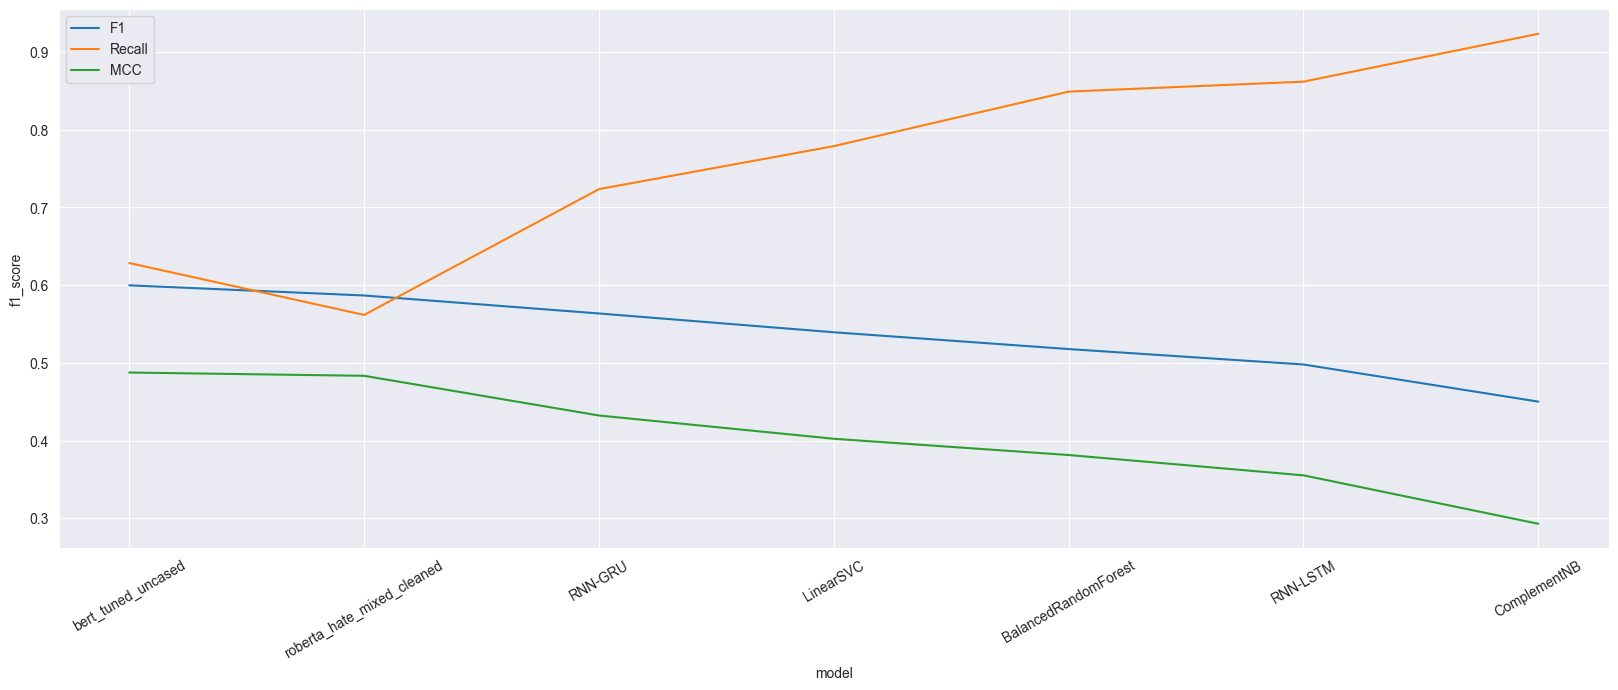

In [82]:
# Filterung nur auf den jeweils besten cleaned Datensatz (für GRU und LSTM der _rnn-Datensatz)
best_cleaned_35 = all_eval_35_dfs[((all_eval_35_dfs.dataset_name == "df_mixed_test_cleaned") & ((all_eval_35_dfs.model != "RNN-GRU") & (all_eval_35_dfs.model != "RNN-LSTM"))) |
                ((all_eval_35_dfs.dataset_name == "df_mixed_test_cleaned_rnn") & ((all_eval_35_dfs.model == "RNN-GRU") | (all_eval_35_dfs.model == "RNN-LSTM")))].sort_values(by=["f1_score"], ascending=False)

fig, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)
sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.f1_score, x=best_cleaned_35.model, label="F1")
sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.recall, x=best_cleaned_35.model, label="Recall")
sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.mcc, x=best_cleaned_35.model, label="MCC")

###### Erkenntnisse Schwellwert 0.35
- manuell gelabelte Datensätze erzielen im Vergleich mit anderen Testdatensätzen auch bei Schwellwert 0.35 die besten Ergebnisse, alle Modelle unter den besten F1-Werten vertreten
- ebenfalls deutliche Unterschiede (-20-25%) zwischen manuell gelabelt und regulären Testdaten (volle Samplesize)
- cleaned erzielt für das jeweilige Modell grundsätzlich die besten Ergebnisse (bei GRU und LSTM der RNN-Datensatz), ansonsten aber im Schnitt 3-5% Unterschied von cleaned zu uncleaned

#### Gesamtvergleich aller Datensätze und Schwellwerte

In [83]:
df_list = [
    all_eval_50_dfs,
    all_eval_35_dfs]

all_eval_dfs = pd.concat(df_list, axis=0)

In [84]:
# allgemeine Sortierung aller Datensätze nach F1-Score
all_eval_dfs.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.35,0.879070,0.883436,0.813559,0.847059,0.749074
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.50,0.879070,0.883436,0.813559,0.847059,0.749074
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.50,0.935286,0.739827,0.985809,0.845286,0.818682
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.35,0.912358,0.673828,0.990963,0.802189,0.771465
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.50,0.923740,0.807912,0.756189,0.781195,0.735669
...,...,...,...,...,...,...,...,...,...
1,ComplementNB,df_mixed_test_cleaned,32466,0.35,0.524549,0.297518,0.923527,0.450050,0.292803
1,ComplementNB,df_mixed_test_uncleaned,32582,0.35,0.404671,0.256564,0.966540,0.405492,0.222343
1,ComplementNB,df_mixed_test_cleaned_rnn,32529,0.35,0.391866,0.253148,0.969316,0.401452,0.213532
1,ComplementNB,df_mixed_train_uncleaned,81905,0.35,0.463024,0.247399,0.970973,0.394326,0.272100


In [85]:
# Filterung nur auf die 3 Testdatensätze und Sortierung nach F1-Score
all_eval_dfs[(all_eval_dfs.dataset_name == "df_mixed_test_cleaned") | (all_eval_dfs.dataset_name == "df_mixed_test_cleaned_rnn") | (all_eval_dfs.dataset_name == "df_mixed_test_uncleaned")].sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.50,0.823292,0.573525,0.628454,0.599735,0.487495
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.35,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.35,0.820929,0.568380,0.618790,0.592515,0.478740
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.50,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.35,0.801869,0.522474,0.677674,0.590039,0.469069
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.50,0.801869,0.522474,0.677674,0.590039,0.469069
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.35,0.833303,0.614069,0.561632,0.586681,0.483293
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.50,0.833303,0.614069,0.561632,0.586681,0.483293
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.35,0.790498,0.500997,0.660579,0.569826,0.442052
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.50,0.790498,0.500997,0.660579,0.569826,0.442052


<Axes: xlabel='model', ylabel='f1_score'>

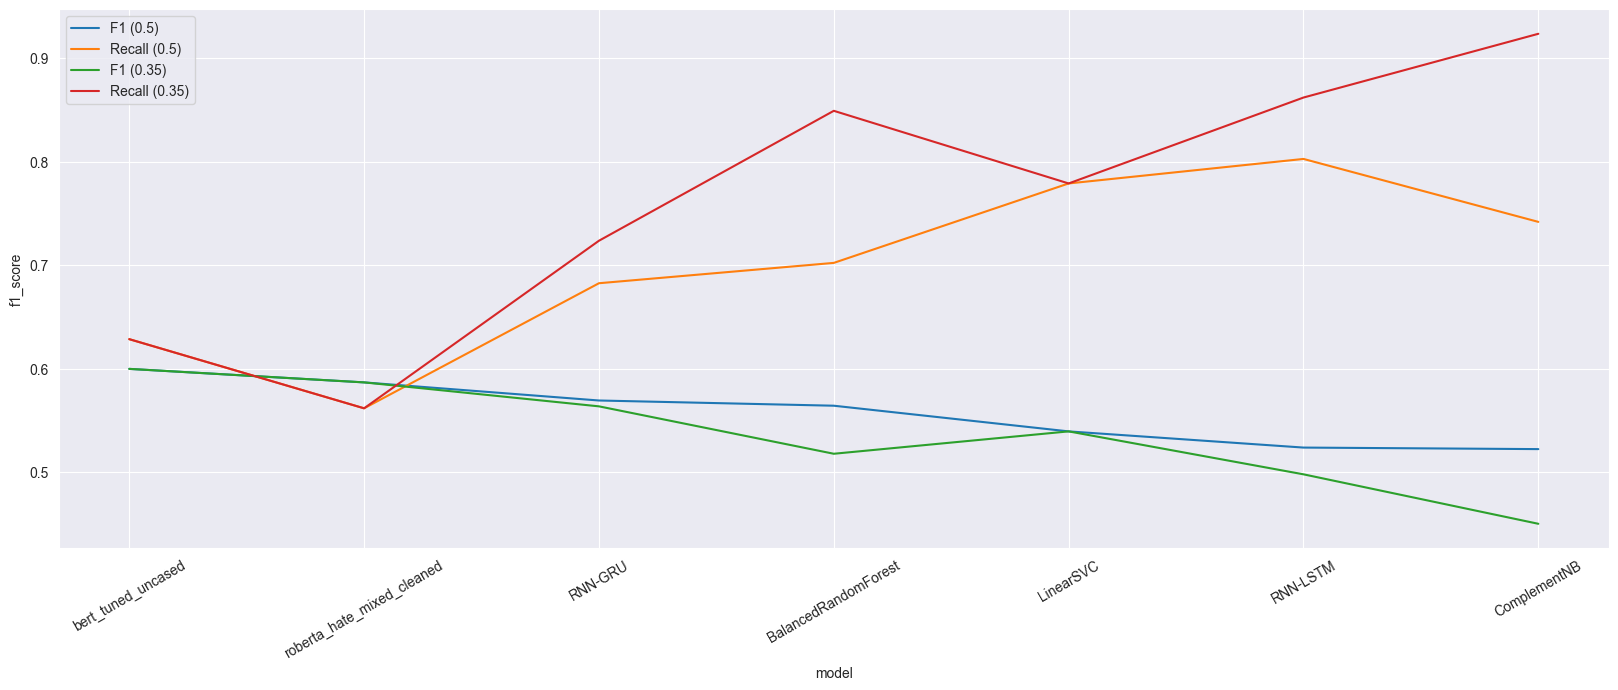

In [86]:
# Vergleich von F1-Score und Recall bei unterschiedlichem Schwellwert für test_cleaned/test_cleaned_rnn
fig, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)

sns.lineplot(data=best_cleaned, y=best_cleaned.f1_score, x=best_cleaned.model, label="F1 (0.5)")
sns.lineplot(data=best_cleaned, y=best_cleaned.recall, x=best_cleaned.model, label="Recall (0.5)")
# sns.lineplot(data=best_cleaned, y=best_cleaned.mcc, x=best_cleaned.model, label="MCC (0.5)")

sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.f1_score, x=best_cleaned_35.model, label="F1 (0.35)")
sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.recall, x=best_cleaned_35.model, label="Recall (0.35)")
# sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.mcc, x=best_cleaned_35.model, label="MCC (0.35)")

In [87]:
# Vergleich von F1-Score und Recall bei unterschiedlichem Schwellwert für test_cleaned/test_cleaned_rnn
all_eval_dfs[(all_eval_dfs.dataset_name == "df_mixed_manual_uncleaned_new") | (all_eval_dfs.dataset_name == "df_mixed_manual_uncleaned_old")].sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.50,0.879070,0.883436,0.813559,0.847059,0.749074
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.35,0.879070,0.883436,0.813559,0.847059,0.749074
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,430,0.35,0.816279,0.766304,0.796610,0.781163,0.623297
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,430,0.50,0.816279,0.766304,0.796610,0.781163,0.623297
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,430,0.35,0.830233,0.791411,0.767857,0.779456,0.641705
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,430,0.50,0.830233,0.791411,0.767857,0.779456,0.641705
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,430,0.35,0.797674,0.716346,0.841808,0.774026,0.599343
4,RNN-GRU,df_mixed_manual_uncleaned_new,430,0.50,0.813953,0.797546,0.734463,0.764706,0.612710
3,RNN-LSTM,df_mixed_manual_uncleaned_new,430,0.50,0.772093,0.670996,0.875706,0.759804,0.567828
2,LinearSVC,df_mixed_manual_uncleaned_new,430,NaN,0.788372,0.723958,0.785311,0.753388,0.570030


##### Fazit
- Unterschied zwischen cleaned vs. uncleaned: cleaned bzw. cleaned_rnn jeweils immer besser als uncleaned
- Unterschied zwischen rnn vs. regulär:
- Unterschied zwischen Schwellwert 0.5 vs. 0.35:
    - verringerter Schwellwert bringt bei keinem Modell auf dem Test-Datensatz eine Verbesserung des F1-Scores; auf den manual-labeled sind Ausnahmen zu erkennen, bei denen sich die Performance von 0.5 zu 0.35 leicht verbessert
    - bei Bert & Roberta gar keine Veränderung => Modelle klassifizieren mit hoher Wahrscheinlichkeit (unabhängig davon, ob die Klassifikation richtig/falsch ist), wenige Grenzfälle
- Beste Modelle
    - auf den Testdaten performen 1. Bert, 2. Roberta, 3. GRU am besten
    - auf den manuell gelabelten Daten performen 1. Roberta, 2. Bert, 3. restliche Modelle mit F1-Score zwischen 77-75% (außer ComplementNB, nur 72%)

### 4. Detaillierte Evaluation - Tweetbetrachtung

Fragen:
- gibt es Tweets, die von keinem Modell korrekt klassifiziert werden können? bzw. nur von wenigen? was haben diese Tweets gemeinsam?
- gibt es Tweets, die von allen Modellen korrekt klassifiziert werden können? bzw. von vielen? was haben diese Tweets gemeinsam?
-


In [88]:
def create_false_tweet_df(tweet_col, label_col, original_df, threshold):
    merged_false = original_df.copy()

    add_pred_and_probas(model=ensemble_model,
                        vectorizer=ensemble_vectorizer,
                        data=merged_false,
                        tweet_name=tweet_col,
                        threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_ens',
                                 'one_proba': '1_ens',
                                 'pred': 'pred_ens'}, inplace=True)

    add_pred_and_probas(model=nb_model,
                        vectorizer=nb_vectorizer,
                        data=merged_false,
                        tweet_name=tweet_col,
                        threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_nb',
                                 'one_proba': '1_nb',
                                 'pred': 'pred_nb'}, inplace=True)

    add_pred_and_probas_svm(model=svm_model,
                            vectorizer=svm_vectorizer,
                            data=merged_false,
                            tweet_name=tweet_col,
                            threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_svm',
                                 'one_proba': '1_svm',
                                 'pred': 'pred_svm'}, inplace=True)

    add_pred_and_probas_lstm(model=lstm_model,
                             tokenizer=lstm_tokenizer,
                             vectorizer=lstm_glove_embeddings,
                             data=merged_false,
                             tweet_name=tweet_col,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_lstm',
                                 'one_proba': '1_lstm',
                                 'pred': 'pred_lstm'}, inplace=True)

    add_pred_and_probas_gru(model=gru_model,
                            tokenizer=gru_tokenizer,
                            data=merged_false,
                            tweet_name=tweet_col,
                            threshold=threshold,
                            max_len=40)
    merged_false.rename(columns={'zero_proba': '0_gru',
                                 'one_proba': '1_gru',
                                 'pred': 'pred_gru'}, inplace=True)

    add_pred_and_probas_bert(model=bert_model,
                             tokenizer=bert_tokenizer,
                             data=merged_false,
                             label_name=label_col,
                             tweet_name=tweet_col,
                             batch_size=16,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_bert',
                                 'one_proba': '1_bert',
                                 'pred': 'pred_bert'}, inplace=True)

    add_pred_and_probas_bert(model=roberta_model,
                             tokenizer=roberta_tokenizer,
                             data=merged_false,
                             label_name=label_col,
                             tweet_name=tweet_col,
                             batch_size=16,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_rob',
                                 'one_proba': '1_rob',
                                 'pred': 'pred_rob'}, inplace=True)

    return merged_false

In [89]:
def get_all_false_merged(merged_false, label_col):
    all_false_merged = merged_false[
        (merged_false.pred_ens != merged_false[label_col]) &
        (merged_false.pred_nb != merged_false[label_col]) &
        (merged_false.pred_svm != merged_false[label_col]) &
        (merged_false.pred_gru != merged_false[label_col]) &
        (merged_false.pred_lstm != merged_false[label_col]) &
        (merged_false.pred_bert != merged_false[label_col]) &
        (merged_false.pred_rob != merged_false[label_col])]

    print("Anzahl falsch vorhergesagter Tweets (von allen Modelle):", len(all_false_merged), "/", len(merged_false),
          "| Anteil: ", round((len(all_false_merged) / len(merged_false) * 100), 2), "%")
    print("-- davon Label 0:", len(all_false_merged[all_false_merged[label_col] == 0]))
    print("-- davon Label 1:", len(all_false_merged[all_false_merged[label_col] == 1]))

    return all_false_merged

In [90]:
def get_num_of_false(df, label_col, model_pred_col):
    return len(
        df[((df[label_col] == 0) & (df[model_pred_col] == 1)) | ((df[label_col] == 1) & (df[model_pred_col] == 0))])

In [91]:
def get_mostly_false_merged(merged_false, label_col):
    merged_false["preds"] = merged_false.pred_ens.values + \
                            merged_false.pred_nb.values + \
                            merged_false.pred_svm.values + \
                            merged_false.pred_gru.values + \
                            merged_false.pred_lstm.values + \
                            merged_false.pred_bert.values + \
                            merged_false.pred_rob.values
    mostly_false_merge = merged_false[((merged_false[label_col] == 0) & (merged_false.preds >= 4)) | (
            (merged_false[label_col] == 1) & (merged_false.preds <= 4))]

    print("Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch):", len(mostly_false_merge), "/", len(merged_false),
          "| Anteil: ", round((len(mostly_false_merge) / len(merged_false) * 100), 2), "%")
    print("-- davon Label 0:", len(mostly_false_merge[mostly_false_merge[label_col] == 0]))
    print("-- davon Label 1:", len(mostly_false_merge[mostly_false_merge[label_col] == 1]))

    print("Modelle:")
    print("-- Ensemble: \t", get_num_of_false(mostly_false_merge, label_col, "pred_ens"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_ens") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- NB: \t\t\t", get_num_of_false(mostly_false_merge, label_col, "pred_nb"), "/", len(mostly_false_merge),
          " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_nb") / len(mostly_false_merge)) * 100, 2),
          "%")
    print("-- SVM: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_svm"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_svm") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- GRU: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_gru"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_gru") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- LSTM: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_lstm"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_lstm") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- BERT: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_bert"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_bert") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- ROBERTA: \t", get_num_of_false(mostly_false_merge, label_col, "pred_rob"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_rob") / len(mostly_false_merge)) * 100, 2), "%")

    return mostly_false_merge

#### 4.1 manuell gelabelte Tweets (new) - Schwellwert 0.5

In [92]:
merged_false_manual1 = pd.read_csv("evaluation_data/merged_false_manual1.csv", index_col=0)

In [93]:
all_false_merged_manual1 = get_all_false_merged(merged_false_manual1, label_col="label_manual")
all_false_merged_manual1

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 7 / 430 | Anteil:  1.63 %
-- davon Label 0: 5
-- davon Label 1: 2


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,0,0,0,...,0.821766,0.178234,0,0.565452,0.434548,0,0.990371,0.009629,0,0
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1,7
12,0,Your gf is a whore I bet,0.21,0.79,1,0.114762,0.885238,1,0,0,...,0.036421,0.963579,1,0.297317,0.702683,1,0.039591,0.960409,1,7
15,0,Somebody find me this fucking pussy ass bitch URL,0.29,0.71,1,0.390066,0.609934,1,0,0,...,0.032229,0.967771,1,0.264960,0.735040,1,0.272777,0.727223,1,7
65,0,Get the fuck out stupid bitch,0.35,0.65,1,0.292034,0.707966,1,0,0,...,0.073379,0.926621,1,0.427763,0.572237,1,0.441481,0.558519,1,7
57,0,You're a retard too so what's one retard repla...,0.23,0.77,1,0.252714,0.747286,1,0,0,...,0.152197,0.847803,1,0.346516,0.653484,1,0.198952,0.801048,1,7
70,1,RT @user: Ô∏èObama swindling future generation...,0.82,0.18,0,0.514828,0.485172,0,0,0,...,0.979549,0.020451,0,0.956755,0.043245,0,0.831532,0.168468,0,0


In [94]:
mostly_false_merged_manual1 = get_mostly_false_merged(merged_false_manual1, label_col="label_manual")
mostly_false_merged_manual1

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 81 / 430 | Anteil:  18.84 %
-- davon Label 0: 42
-- davon Label 1: 39
Modelle:
-- Ensemble: 	 63 / 81  -  77.78 %
-- NB: 			 48 / 81  -  59.26 %
-- SVM: 		 57 / 81  -  70.37 %
-- GRU: 		 51 / 81  -  62.96 %
-- LSTM: 		 62 / 81  -  76.54 %
-- BERT: 		 57 / 81  -  70.37 %
-- ROBERTA: 	 35 / 81  -  43.21 %


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
10,1,"Close your fucking legs, hoe. Use birth contro...",0.60,0.40,0,0.527259,0.472741,0,0,0,...,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1,4
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,4
80,1,@user Fuck education they need castration,0.50,0.50,1,0.378660,0.621340,1,0,0,...,0.823851,0.176149,0,0.649839,0.350161,0,0.118078,0.881922,1,4
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,0,0,0,...,0.821766,0.178234,0,0.565452,0.434548,0,0.990371,0.009629,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,This is what happens when you let gays Marry,0.92,0.08,0,0.426424,0.573576,1,0,0,...,0.998126,0.001874,0,0.358095,0.641905,1,0.985978,0.014022,0,2
77,0,Never ask your gay friends to hide their ident...,0.18,0.82,1,0.451460,0.548540,1,0,0,...,0.128082,0.871918,1,0.356391,0.643609,1,0.990366,0.009634,0,6
84,0,I'm delighted no one should bye anything from ...,0.67,0.33,0,0.302098,0.697902,1,0,0,...,0.241193,0.758807,1,0.571151,0.428849,0,0.606780,0.393220,0,4
85,0,John Marksman wtf she's a little girl. Fucking...,0.18,0.82,1,0.263713,0.736287,1,0,0,...,0.288606,0.711394,1,0.588637,0.411363,0,0.932846,0.067154,0,5


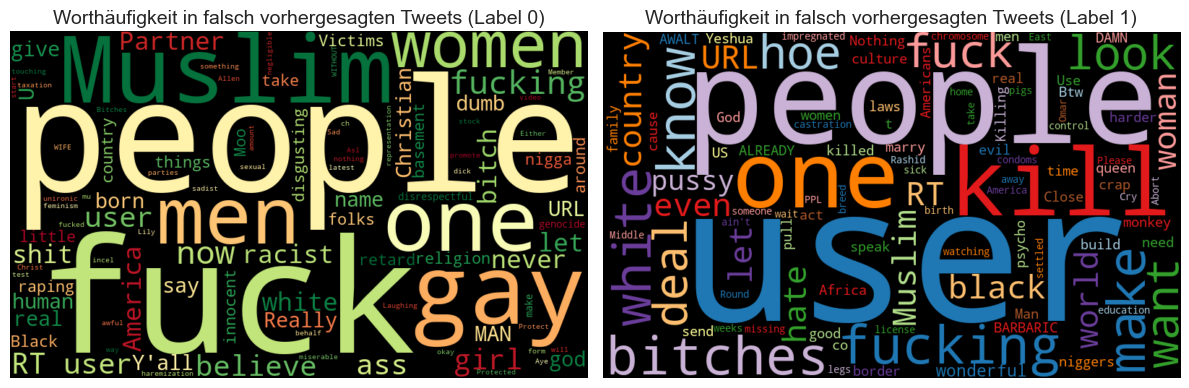

In [95]:
print_wordcloud(mostly_false_merged_manual1, tweet_col="tweet", label_col="label_manual")

##### Erkenntnisse
- falsch von allen Modellen sehr gering (<2%)
- Mehrheit falsch schon ~18.8%
- Tweets bei allen falsch: vorhergesagt als 1 (true 0) enthalten zwar (krasse) Beleidigungen, sind aber kein Hate Speech
- Label 1 bei Mehrheit falsch: enthält Schlagworte, die man mit Hate Speech in Verbindung bringen könnte bzw. die häufig in HS-Tweets vorkommen (Personengruppen wie muslim, women oder Beleidigungen wie bitch, gay (gay an sich keine Beleidigung, wird aber häufig als solche verwendet))
- Label 0 bei Mehrheit falsch: die Schlagworte für HS fehlen bzw. kommen nicht so häufig vor

#### 4.2 manuell gelabelte Tweets (new) - Schwellwert 0.35

In [96]:
merged_false_manual2 = pd.read_csv("evaluation_data/merged_false_manual2.csv", index_col=0)

In [97]:
all_false_merged_manual2 = get_all_false_merged(merged_false_manual2, label_col="label_manual")
all_false_merged_manual2

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 7 / 430 | Anteil:  1.63 %
-- davon Label 0: 7
-- davon Label 1: 0


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
66,0,RT @user: We Muslims have no military honour w...,0.46,0.54,1,0.214399,0.785601,1,0,0,...,0.006515,0.993485,1,0.596255,0.403745,1,0.008101,0.991899,1,7
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1,7
12,0,Your gf is a whore I bet,0.21,0.79,1,0.114762,0.885238,1,0,0,...,0.036421,0.963579,1,0.297317,0.702683,1,0.039591,0.960409,1,7
15,0,Somebody find me this fucking pussy ass bitch URL,0.29,0.71,1,0.390066,0.609934,1,0,0,...,0.032229,0.967771,1,0.264960,0.735040,1,0.272777,0.727223,1,7
65,0,Get the fuck out stupid bitch,0.35,0.65,1,0.292034,0.707966,1,0,0,...,0.073379,0.926621,1,0.427763,0.572237,1,0.441481,0.558519,1,7
74,0,RT @user: Wat type of bitch ass nigga rape a i...,0.38,0.62,1,0.450220,0.549780,1,0,0,...,0.505137,0.494863,1,0.359640,0.640360,1,0.085985,0.914015,1,7
57,0,You're a retard too so what's one retard repla...,0.23,0.77,1,0.252714,0.747286,1,0,0,...,0.152197,0.847803,1,0.346516,0.653484,1,0.198952,0.801048,1,7


In [98]:
mostly_false_merged_manual2 = get_mostly_false_merged(merged_false_manual2, label_col="label_manual")
mostly_false_merged_manual2

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 85 / 430 | Anteil:  19.77 %
-- davon Label 0: 56
-- davon Label 1: 29
Modelle:
-- Ensemble: 	 63 / 85  -  74.12 %
-- NB: 			 58 / 85  -  68.24 %
-- SVM: 		 57 / 85  -  67.06 %
-- GRU: 		 56 / 85  -  65.88 %
-- LSTM: 		 68 / 85  -  80.0 %
-- BERT: 		 63 / 85  -  74.12 %
-- ROBERTA: 	 37 / 85  -  43.53 %


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,4
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,1,0,0,...,0.821766,0.178234,0,0.565452,0.434548,1,0.990371,0.009629,0,2
16,0,illegal immigrants =/= legal immigrants. in ev...,0.59,0.41,1,0.398594,0.601406,1,0,0,...,0.497590,0.502410,1,0.780791,0.219209,0,0.975723,0.024277,0,4
21,0,unironic incel parties will start to form. no ...,0.75,0.25,0,0.556272,0.443728,1,0,0,...,0.036047,0.963953,1,0.194741,0.805259,1,0.442455,0.557545,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,This is what happens when you let gays Marry,0.92,0.08,0,0.426424,0.573576,1,0,0,...,0.998126,0.001874,0,0.358095,0.641905,1,0.985978,0.014022,0,2
77,0,Never ask your gay friends to hide their ident...,0.18,0.82,1,0.451460,0.548540,1,0,0,...,0.128082,0.871918,1,0.356391,0.643609,1,0.990366,0.009634,0,6
84,0,I'm delighted no one should bye anything from ...,0.67,0.33,0,0.302098,0.697902,1,0,0,...,0.241193,0.758807,1,0.571151,0.428849,1,0.606780,0.393220,1,6
85,0,John Marksman wtf she's a little girl. Fucking...,0.18,0.82,1,0.263713,0.736287,1,0,0,...,0.288606,0.711394,1,0.588637,0.411363,1,0.932846,0.067154,0,6


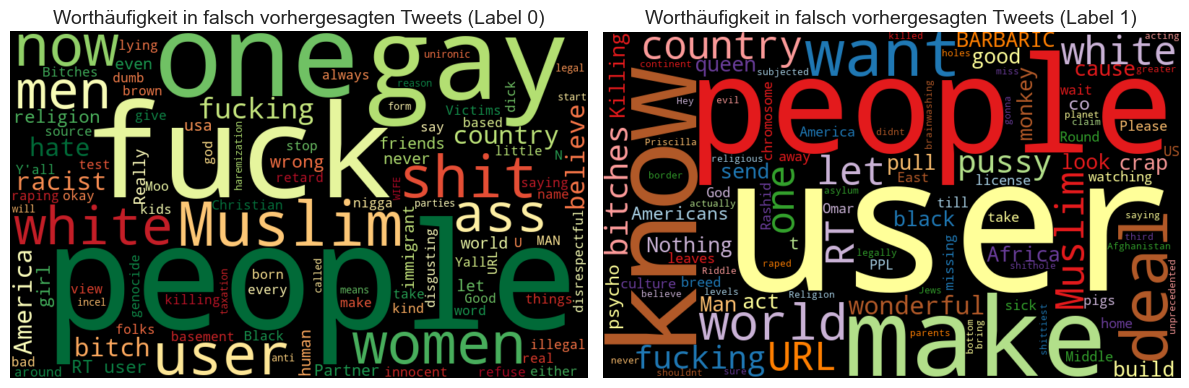

In [99]:
print_wordcloud(mostly_false_merged_manual2, tweet_col="tweet", label_col="label_manual")

##### Erkenntnisse
- falsch von allen Modellen sehr gering (<2%) => es sind aber nicht (alles) die selben Tweets wie beim Schwellwert 0.5!
- Mehrheit falsch schon 19.8% (4 Tweets mehr => deckt sich mit Kapitel 3, in denen ersichtlich ist, dass durch den verringerten Schwellwert kein Performancegewinn erzielt wird)
Rest wie bei Schwellwert 0.5
- Tweets bei allen falsch: vorhergesagt als 1 (true 0) enthalten zwar (krasse) Beleidigungen, sind aber kein Hate Speech
- Label 1 bei Mehrheit falsch: enthält Schlagworte, die man mit Hate Speech in Verbindung bringen könnte bzw. die häufig in HS-Tweets vorkommen (Personengruppen wie muslim, women oder Beleidigungen wie bitch, gay (gay an sich keine Beleidigung, wird aber häufig als solche verwendet))
- Label 0 bei Mehrheit falsch: die Schlagworte für HS fehlen bzw. kommen nicht so häufig vor

#### 4.3 Mixed-Test cleaned - Schwellwert 0.5

In [103]:
merged_false_tweet_cleaned1 = pd.read_csv("evaluation_data/merged_false_tweet_cleaned1.csv", index_col=0)

In [104]:
merged_false_tweet_cleaned1

,label,tweet_cleaned,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
8886,0,final gear evening butterfly stage hope like,0.75,0.25,0,0.836110,0.163890,0,0,0,...,0.999995,0.000005,0,0.998820,0.001180,0,0.999381,0.000619,0,0
27613,0,amazing weather musical london weekend …,1.00,0.00,0,0.991430,0.008570,0,0,0,...,0.999929,0.000071,0,0.998384,0.001616,0,0.999394,0.000606,0,0
18952,0,child attack alligator disney world,0.81,0.19,0,0.825607,0.174393,0,0,0,...,0.924563,0.075437,0,0.985559,0.014441,0,0.999216,0.000784,0,0
12485,0,right cause school soon,0.70,0.30,0,0.592160,0.407840,0,0,0,...,0.995754,0.004246,0,0.917947,0.082052,0,0.996966,0.003034,0,0
5879,0,good sleep good sleep,0.83,0.17,0,0.649481,0.350519,0,0,0,...,0.999758,0.000242,0,0.996236,0.003764,0,0.997868,0.002132,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176360,0,even liberal humiliate charlie claim gop back ...,0.69,0.31,0,0.548318,0.451682,0,0,0,...,0.896264,0.103736,0,0.274048,0.725952,1,0.904447,0.095553,0,3
176366,0,photoshop nig,0.71,0.29,0,0.363628,0.636372,1,0,0,...,0.990894,0.009106,0,0.943315,0.056685,0,0.976689,0.023311,0,2
176384,0,mad hoe ask beavis get nothing butthead,0.78,0.22,0,0.473839,0.526161,1,0,0,...,0.998860,0.001140,0,0.350978,0.649022,1,0.997482,0.002518,0,3
176385,0,child concentration camp bad enough trump admi...,0.64,0.36,0,0.624282,0.375718,0,0,0,...,0.887528,0.112472,0,0.927335,0.072665,0,0.981390,0.018610,0,1


In [105]:
all_false_merged_tweet_cleaned1 = get_all_false_merged(merged_false_tweet_cleaned1, label_col="label")
all_false_merged_tweet_cleaned1

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 1492 / 32466 | Anteil:  4.6 %
-- davon Label 0: 1061
-- davon Label 1: 431


,label,tweet_cleaned,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
24456,1,sleep night terrible person sir represent ever...,0.83,0.17,0,0.680407,0.319593,0,0,0,...,0.961663,0.038337,0,0.957003,0.042997,0,0.995046,0.004954,0,0
17424,1,peek nyc come back holy,0.88,0.12,0,0.515980,0.484020,0,0,0,...,0.999588,0.000412,0,0.997054,0.002946,0,0.999180,0.000820,0,0
5087,1,""" workplace family responsibility add pressure...",0.92,0.08,0,0.713795,0.286205,0,0,0,...,0.997584,0.002416,0,0.794114,0.205886,0,0.999021,0.000979,0,0
21727,1,note able pop neck day day …,0.92,0.08,0,0.812397,0.187603,0,0,0,...,0.994909,0.005091,0,0.998480,0.001520,0,0.999331,0.000669,0,0
22001,1,ya prince charles - issue warning trump return...,0.61,0.39,0,0.606323,0.393677,0,0,0,...,0.999924,0.000076,0,0.966566,0.033434,0,0.899878,0.100122,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175707,0,drown hypocrisy show empathy woman provide sou...,0.22,0.78,1,0.357373,0.642627,1,0,0,...,0.466319,0.533681,1,0.338639,0.661361,1,0.133942,0.866058,1,7
175755,0,pussy ass niggas,0.31,0.69,1,0.255930,0.744070,1,0,0,...,0.292038,0.707962,1,0.242580,0.757420,1,0.092577,0.907423,1,7
176221,0,well woman deserve murder incel never conseque...,0.17,0.83,1,0.201791,0.798209,1,0,0,...,0.168841,0.831159,1,0.283943,0.716057,1,0.425188,0.574812,1,7
176224,1,another subreddit outcome beautiful woman need...,0.81,0.19,0,0.670378,0.329622,0,0,0,...,0.999822,0.000178,0,0.997102,0.002898,0,0.999110,0.000890,0,0


In [106]:
mostly_false_merged_tweet_cleaned1 = get_mostly_false_merged(merged_false_tweet_cleaned1, label_col="label")
mostly_false_merged_tweet_cleaned1

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 7648 / 32466 | Anteil:  23.56 %
-- davon Label 0: 5198
-- davon Label 1: 2450
Modelle:
-- Ensemble: 	 5919 / 7648  -  77.39 %
-- NB: 			 6099 / 7648  -  79.75 %
-- SVM: 		 6323 / 7648  -  82.68 %
-- GRU: 		 5634 / 7648  -  73.67 %
-- LSTM: 		 6002 / 7648  -  78.48 %
-- BERT: 		 4942 / 7648  -  64.62 %
-- ROBERTA: 	 4306 / 7648  -  56.3 %


,label,tweet_cleaned,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
6640,1,misogyny alive well left never let tell,0.41,0.59,1,0.447158,0.552842,1,0,0,...,0.900734,0.099266,0,0.658825,0.341175,0,0.985618,0.014382,0,4
26538,1,never room school board ever kid school future,0.70,0.30,0,0.572453,0.427547,0,0,0,...,0.818643,0.181357,0,0.990094,0.009906,0,0.948021,0.051978,0,1
13046,0,oh gosh freaking kill president,0.35,0.65,1,0.399097,0.600903,1,0,0,...,0.194005,0.805995,1,0.587686,0.412314,0,0.560537,0.439463,0,5
24456,1,sleep night terrible person sir represent ever...,0.83,0.17,0,0.680407,0.319593,0,0,0,...,0.961663,0.038337,0,0.957003,0.042997,0,0.995046,0.004954,0,0
168,1,point one finger million point right back,0.54,0.46,0,0.551959,0.448041,0,0,0,...,0.230771,0.769229,1,0.870135,0.129865,0,0.998511,0.001489,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176224,1,another subreddit outcome beautiful woman need...,0.81,0.19,0,0.670378,0.329622,0,0,0,...,0.999822,0.000178,0,0.997102,0.002898,0,0.999110,0.000890,0,0
176252,0,little bitch would masturbate cus nonce stupid...,0.54,0.46,0,0.324064,0.675936,1,0,0,...,0.085027,0.914973,1,0.589835,0.410165,0,0.827502,0.172498,0,4
176287,0,white school teacher back elementary know give...,0.28,0.72,1,0.631280,0.368720,0,0,0,...,0.043912,0.956088,1,0.744024,0.255976,0,0.884535,0.115465,0,4
176290,0,kill religion,0.43,0.57,1,0.328023,0.671977,1,0,0,...,0.627487,0.372513,0,0.592711,0.407289,0,0.965532,0.034468,0,4


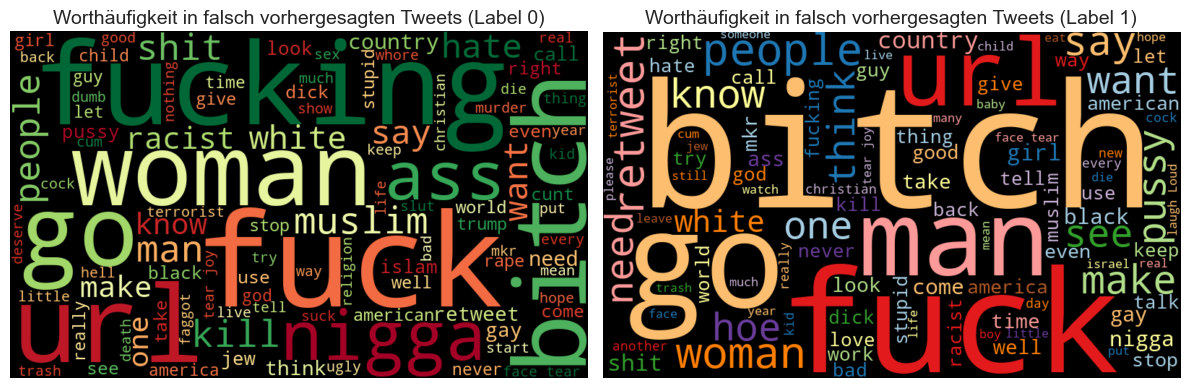

In [108]:
print_wordcloud(mostly_false_merged_tweet_cleaned1, tweet_col="tweet_cleaned", label_col="label")

#### 4.4 Mixed-Test cleaned - Schwellwert 0.35

In [ ]:
merged_false_tweet_cleaned2 = pd.read_csv("evaluation_data/merged_false_tweet_cleaned2.csv", index_col=0)

In [ ]:
merged_false_tweet_cleaned2

In [ ]:
all_false_merged_tweet_cleaned2 = get_all_false_merged(merged_false_tweet_cleaned2, label_col="label")
all_false_merged_tweet_cleaned2

In [ ]:
mostly_false_merged_tweet_cleaned2 = get_mostly_false_merged(merged_false_tweet_cleaned2, label_col="label")
mostly_false_merged_tweet_cleaned2

In [ ]:
print_wordcloud(mostly_false_merged_tweet_cleaned2, tweet_col="tweet_cleaned", label_col="label")

### 5. Vergleich manuell gelabelt new vs. old

#### 5.1 Allgemeiner Metrikenvergleich

In [100]:
manual_new_metrics1 = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new.csv")
manual_new_metrics1

,Unnamed: 0,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
0,0,BalancedRandomForest,df_mixed_manual_uncleaned_new,430,0.5,0.793023,0.775000,0.700565,0.735905,0.568396
1,1,ComplementNB,df_mixed_manual_uncleaned_new,430,0.5,0.718605,0.603704,0.920904,0.729306,0.507009
2,2,LinearSVC,df_mixed_manual_uncleaned_new,430,NaN,0.788372,0.723958,0.785311,0.753388,0.570030
3,3,RNN-LSTM,df_mixed_manual_uncleaned_new,430,0.5,0.772093,0.670996,0.875706,0.759804,0.567828
4,4,RNN-GRU,df_mixed_manual_uncleaned_new,430,0.5,0.813953,0.797546,0.734463,0.764706,0.612710
5,5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,430,0.5,0.816279,0.766304,0.796610,0.781163,0.623297
6,6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,430,0.5,0.879070,0.883436,0.813559,0.847059,0.749074


In [101]:
manual_old_metrics1 = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old.csv")
manual_old_metrics1

,Unnamed: 0,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
0,0,BalancedRandomForest,df_mixed_manual_uncleaned_old,430,0.5,0.758140,0.700000,0.666667,0.682927,0.488005
1,1,ComplementNB,df_mixed_manual_uncleaned_old,430,0.5,0.669767,0.548148,0.880952,0.675799,0.419207
2,2,LinearSVC,df_mixed_manual_uncleaned_old,430,NaN,0.767442,0.677083,0.773810,0.722222,0.527201
3,3,RNN-LSTM,df_mixed_manual_uncleaned_old,430,0.5,0.741860,0.623377,0.857143,0.721805,0.513807
4,4,RNN-GRU,df_mixed_manual_uncleaned_old,430,0.5,0.797674,0.748466,0.726190,0.737160,0.572933
5,5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,430,0.5,0.786047,0.706522,0.773810,0.738636,0.559822
6,6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,430,0.5,0.830233,0.791411,0.767857,0.779456,0.641705


<Axes: xlabel='model', ylabel='f1_score'>

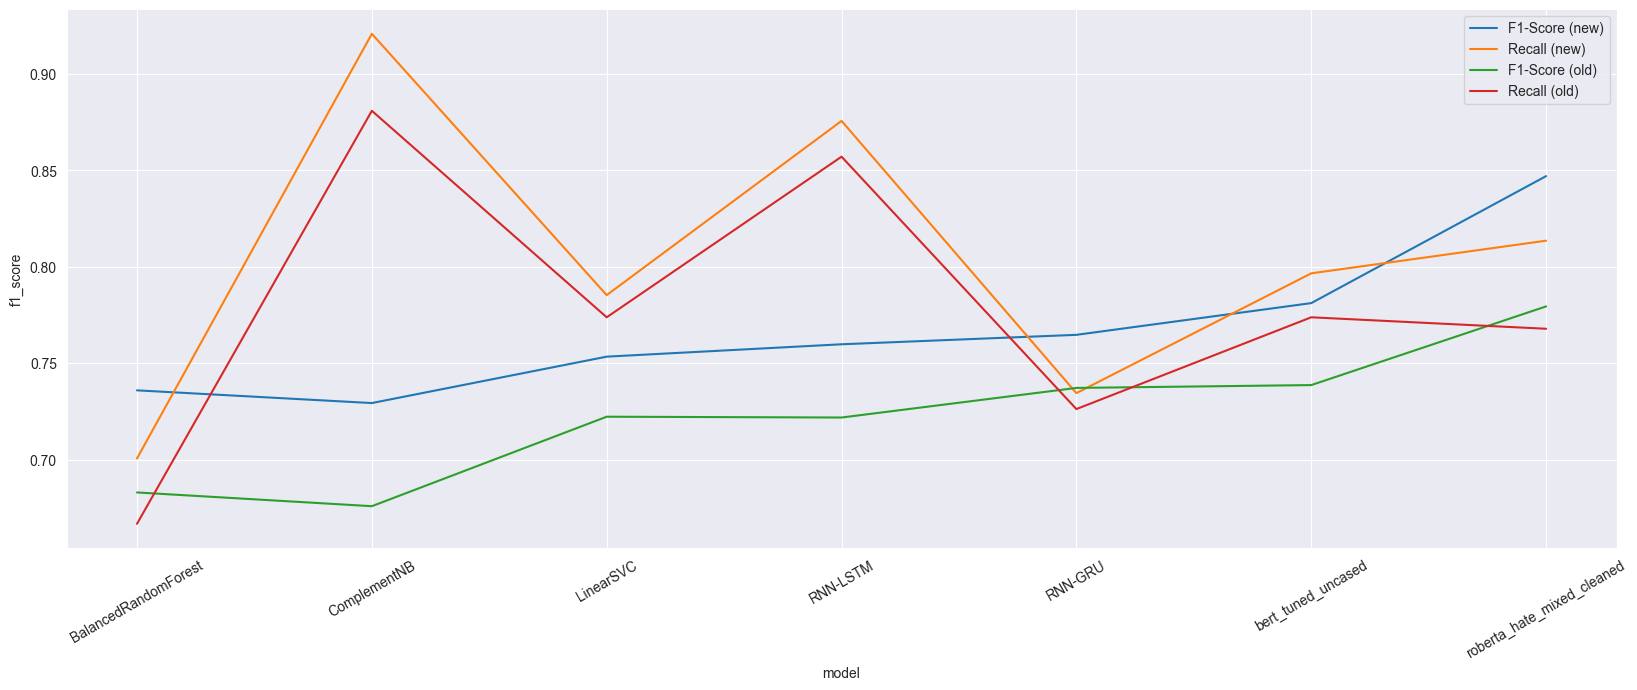

In [102]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)
sns.lineplot(data=manual_new_metrics1, y=manual_new_metrics1.f1_score, x=manual_new_metrics1.model,
             label="F1-Score (new)")
sns.lineplot(data=manual_new_metrics1, y=manual_new_metrics1.recall, x=manual_new_metrics1.model, label="Recall (new)")
sns.lineplot(data=manual_old_metrics1, y=manual_old_metrics1.f1_score, x=manual_old_metrics1.model,
             label="F1-Score (old)")
sns.lineplot(data=manual_old_metrics1, y=manual_old_metrics1.recall, x=manual_old_metrics1.model, label="Recall (old)")

### 6. Erkenntisse aus allen Analysen

#### 6.1 Erkenntisse Kapitel 3
- Unterschied zwischen cleaned vs. uncleaned: cleaned bzw. cleaned_rnn jeweils immer besser als uncleaned
- Unterschied zwischen rnn vs. regulär:
- Unterschied zwischen Schwellwert 0.5 vs. 0.35:
    - verringerter Schwellwert bringt bei keinem Modell auf dem Test-Datensatz eine Verbesserung des F1-Scores; auf den manual-labeled sind Ausnahmen zu erkennen, bei denen sich die Performance von 0.5 zu 0.35 leicht verbessert
    - bei Bert & Roberta gar keine Veränderung => Modelle klassifizieren mit hoher Wahrscheinlichkeit (unabhängig davon, ob die Klassifikation richtig/falsch ist), wenige Grenzfälle
- Beste Modelle
    - auf den Testdaten performen 1. Bert, 2. Roberta, 3. GRU am besten
    - auf den manuell gelabelten Daten performen 1. Roberta, 2. Bert, 3. restliche Modelle mit F1-Score zwischen 81-79%

#### 6.2 Erkenntisse Kapitel 4 - Detaillierte Evaluation/Tweetbetrachtung

##### Erkenntnisse 4.1 (Schwellwert 0.5)
- falsch von allen Modellen sehr gering (<2%)
- Mehrheit falsch schon 18.8%
- Tweets bei allen falsch: vorhergesagt als 1 (true 0) enthalten zwar (krasse) Beleidigungen, sind aber kein Hate Speech
- Label 1 bei Mehrheit falsch: enthält Schlagworte, die man mit Hate Speech in Verbindung bringen könnte bzw. die häufig in HS-Tweets vorkommen (Personengruppen wie muslim, women oder Beleidigungen wie bitch, gay (gay an sich keine Beleidigung, wird aber häufig als solche verwendet))
- Label 0 bei Mehrheit falsch: die Schlagworte für HS fehlen bzw. kommen nicht so häufig vor

##### Erkenntnisse 4.2 (Schwellwert 0.35)
- falsch von allen Modellen sehr gering (<2%) => es sind aber nicht (alles) die selben Tweets wie beim Schwellwert 0.5!
- Mehrheit falsch schon 19.8% (4 Tweets mehr => deckt sich mit Kapitel 3, in denen ersichtlich ist, dass durch den verringerten Schwellwert kein Performancegewinn erzielt wird)
Rest wie bei Schwellwert 0.5
- Tweets bei allen falsch: vorhergesagt als 1 (true 0) enthalten zwar (krasse) Beleidigungen, sind aber kein Hate Speech
- Label 1 bei Mehrheit falsch: enthält Schlagworte, die man mit Hate Speech in Verbindung bringen könnte bzw. die häufig in HS-Tweets vorkommen (Personengruppen wie muslim, women oder Beleidigungen wie bitch, gay (gay an sich keine Beleidigung, wird aber häufig als solche verwendet))
- Label 0 bei Mehrheit falsch: die Schlagworte für HS fehlen bzw. kommen nicht so häufig vor

##### Erkenntnisse 4.3 (Schwellwert 0.5)

##### Erkenntnisse 4.4 (Schwellwert 0.35)

#### 6.3 Erkenntisse Kapitel 5